In [16]:
import numpy as np
import numpy.random as R
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import qmc

import global_as

epsilon = 0.001
def dFunc(x):
    chi, dim = x.shape[0], x.shape[1]
    xe = np.tile(x.transpose(), dim).transpose()+np.repeat(np.array(np.identity(dim)*epsilon), chi, axis=0)
    return ((Func(xe)-np.tile(Func(x),dim))/epsilon).reshape(dim,chi)

In [18]:
dim = 10
theta = np.array(np.arange(1,dim+1,1)) 
chi = 10000
def Func(x):
    x = x - 0.5
    return x@theta + 0*(x[:,0]*x[:,1] - x[:,-1]*x[:,-2]) + 1*R.normal(0,1,x.shape[0]) 

sample_list = []
for i in range(10):
    z3 = R.uniform(0, 1, (100000, dim))
    sample_list.append(np.mean(Func(z3)))
sample_list = sum(sample_list)/len(sample_list)
sigma2 = sum((Func(R.uniform(0, 1, (100000, dim))) - sample_list)**2)/100000
sigma2

33.29710050178717

In [19]:
### Calculate upper and lower Sobol' indices
x, z, w = R.uniform(0, 1, (chi, dim)), R.uniform(0, 1, (chi, dim)), R.uniform(0, 1, (chi, dim))
upper, lower = [], []
for i in range(dim):
    fx, fz = Func(x), Func(z)
    x_uz, z_ux, w_ux = z.copy(), x.copy(), x.copy()
    x_uz[:,i], z_ux[:,i], w_ux[:,i] = x[:,i], z[:,i], w[:,i]
    upper.append(0.5*sum((fx - Func(z_ux))**2)/chi/sigma2)
    lower.append(sum((Func(x_uz) - fz)*(fx - Func(w_ux)))/chi/sigma2)
lower = [min(lower[i], upper[i]) for i in range(len(lower))]
print(upper)
print(lower)

[0.03263725847446548, 0.03971607617223291, 0.05283793544182233, 0.06770656037512757, 0.09253581223606323, 0.11545910797136216, 0.1517248099361645, 0.19131167325350956, 0.23144705558010573, 0.28027531498893266]
[0.00305227778737732, 0.008754062205965054, 0.02214036581959883, 0.039062412201684577, 0.05918021836084785, 0.0863571113865724, 0.1204717683815129, 0.16201044829176403, 0.20568709414669922, 0.2420621554458811]


In [20]:
### Calculate DGSM and full global activity scores
epsilon = 10**-3
z = R.uniform(0, 1, (chi, dim))
deriv = dFunc(z)
deriv /= np.sqrt(chi)
uo, so, vho = np.linalg.svd(deriv.astype(float), full_matrices=True)  
so = so**2
DGSM = uo**2@so/sum(uo**2@so)

u, s = global_as.GAS(Func,dim,chi,10000,1,shiftedSobol=True, distribution = 'uniform') 
gas_score_full = u**2@s/sum(u**2@s)

[0.54684865 0.59979682 0.65211432 0.70343126 0.75433947 0.80476638
 0.85439847 0.90364115 0.95240631 1.        ]
[0.84489689 0.86309224 0.88105953 0.89896617 0.91629029 0.93351428
 0.95050217 0.96718142 0.98378647 1.        ]


Text(0.5, 1.0, 'The 1st eigenvectors')

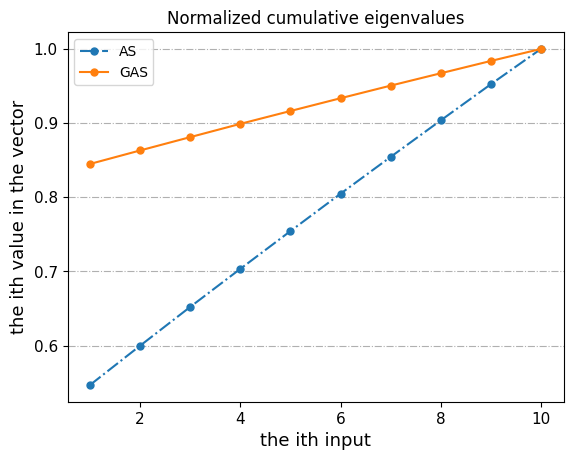

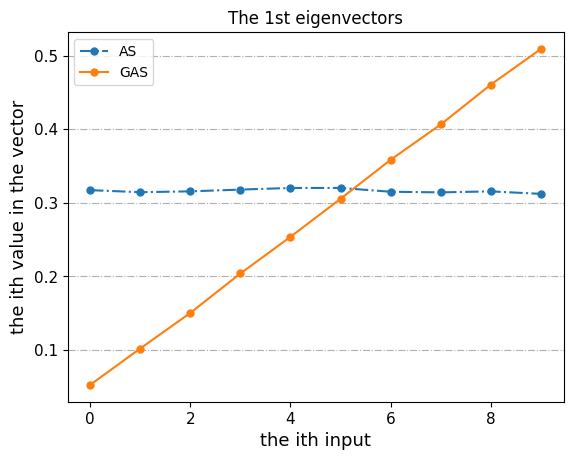

In [21]:
### Plot eigenvalues and eigenvectors
x=np.arange(1,1+len(s),1)
fig,ax=plt.subplots(figsize=(6.4,4.8), dpi=100)
colorc=plt.rcParams['axes.prop_cycle'].by_key()['color']
ax.plot(x,np.cumsum(so)/np.sum(so), label='AS', c=colorc[0], linestyle='-.', marker='.', markersize='10')
print(np.cumsum(so)/np.sum(so))
ax.plot(x,np.cumsum(s)/np.sum(s), label='GAS', c=colorc[1], linestyle='-', marker='.', markersize='10')
print(np.cumsum(s)/np.sum(s))
ax.set_xlabel('the ith input', fontsize=13)
ax.set_ylabel('the ith value in the vector', fontsize=13)
ax.tick_params(axis='both', labelsize=11)
ax.yaxis.grid(True, linestyle='-.')

legend = ax.legend(loc='best')
plt.title('Normalized cumulative eigenvalues') 
plt.savefig('gascore_paper/00E1.png')

x=np.arange(0,len(s),1)
fig,ax=plt.subplots(figsize=(6.4,4.8), dpi=100)
colorc=plt.rcParams['axes.prop_cycle'].by_key()['color']
ax.plot(x,-uo[:,0], label='AS', c=colorc[0], linestyle='-.', marker='.', markersize='10')
ax.plot(x,-u[:,0], label='GAS', c=colorc[1], linestyle='-', marker='.', markersize='10')
ax.set_xlabel('the ith input', fontsize=13)
ax.set_ylabel('the ith value in the vector', fontsize=13)
ax.tick_params(axis='both', labelsize=11)
ax.yaxis.grid(True, linestyle='-.')

legend = ax.legend(loc='best')
plt.title('The 1st eigenvectors') 
plt.savefig('gascore_paper/00E2.png')

In [14]:
### Calculate activity scores and global activity scores
d1 = 5
as_score = uo[:,:d1]**2@so[:d1]/sum(uo[:,:d1]**2@so[:d1])
print(as_score)
d1 = 8
gas_score = u[:,:d1]**2@s[:d1]/sum(u[:,:d1]**2@s[:d1])
print(gas_score)

[0.08465578 0.09385113 0.08892342 0.08368537 0.11985189 0.11302245
 0.10156124 0.08873036 0.10790305 0.11781533]
[0.01429586 0.02204267 0.03789879 0.05345115 0.0652999  0.09655747
 0.12320606 0.15799883 0.19525103 0.23399824]


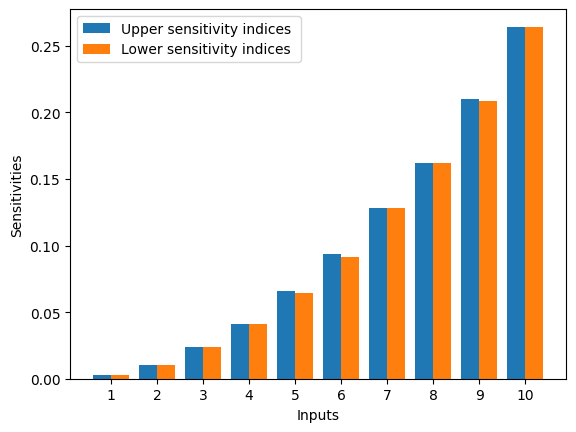

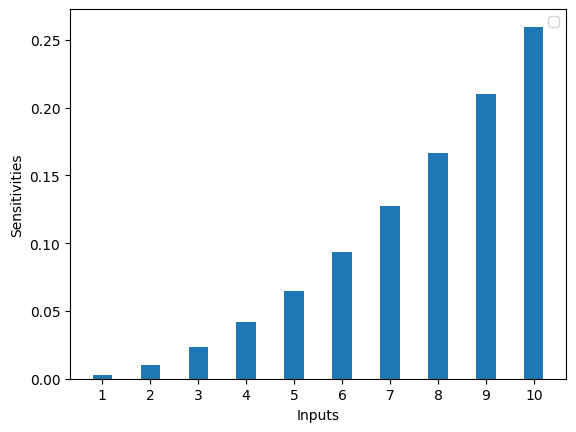

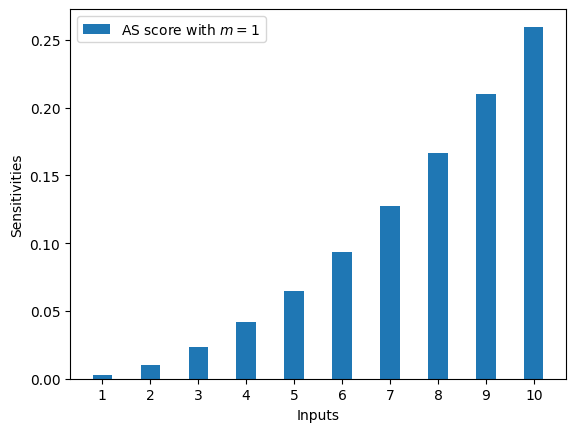

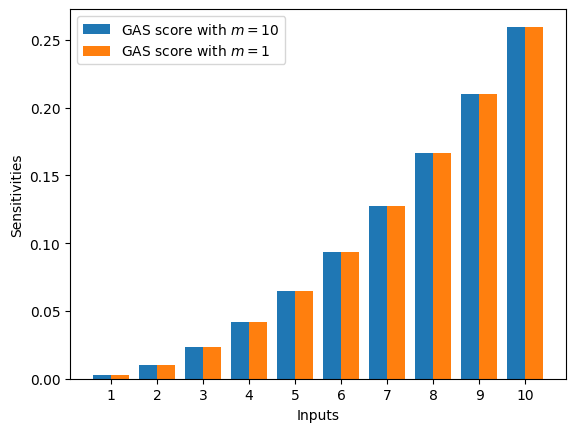

In [74]:
### Plot all indices
width = 0.4
x = np.arange(1,dim+1)
labels = x
fig, ax1 = plt.subplots()
rects1 = ax1.bar(x-width/2, upper, width, label='Upper sensitivity indices')
rects2 = ax1.bar(x+width/2, lower, width, label='Lower sensitivity indices ')
ax1.set_ylabel('Sensitivities')
ax1.set_xlabel('Inputs')
ax1.set_xticks(x)
ax1.legend(loc='upper left')
plt.savefig('gascore_paper/sobol00.png')

fig, ax2 = plt.subplots()
rects1 = ax2.bar(x, DGSM, width)
ax2.set_ylabel('Sensitivities')
ax2.set_xlabel('Inputs')
ax2.set_xticks(x)
ax2.legend()
plt.savefig('gascore_paper/dgsm00.png')

fig, ax3 = plt.subplots()
rects1 = ax3.bar(x, as_score, width, label='AS score with $m = 1$')
ax3.set_ylabel('Sensitivities')
ax3.set_xlabel('Inputs')
ax3.set_xticks(x)
ax3.legend(loc='upper left')
plt.savefig('gascore_paper/as00.png')

fig, ax4 = plt.subplots()
rects1 = ax4.bar(x-width/2, gas_score_full, width, label='GAS score with $m = 10$')
rects2 = ax4.bar(x+width/2, gas_score, width, label='GAS score with $m = 1$')
ax4.set_ylabel('Sensitivities')
ax4.set_xlabel('Inputs')
ax4.set_xticks(x)
ax4.legend(loc='upper left')
plt.savefig('gascore_paper/gas00.png')